In [39]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import  classification_report
import features as features
import utilities as util
import timeit


In [40]:
'''
parms: train data (X_train)
       test data  (X_test)
       train classes  (y_train)

----------------------------

returns: test classes  (y_test)
'''


def svm_train(X_train,y_train, kernel='rbf'):
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
    return clf

In [41]:
'''
parms: train data (X_train)
       test data  (X_test)
       train classes  (y_train)

----------------------------

returns: test classes  (y_test)
'''

def random_forest_train(X_train,y_train, max_depth=2, n_estimators=50):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators)
    clf.fit(X_train, y_train)
#     y_pred=clf.predict(X_test)
    return clf

In [42]:
'''
parms: train data (X_train)
       test data  (X_test)
       train classes  (y_train)

----------------------------

returns: test classes  (y_test)
'''

def knn_train(X_train,y_train, n_neighbors=5):
        neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
        neigh.fit(X_train, y_train)
       #  y_pred=neigh.predict(X_test)
        return neigh

In [43]:
'''
parms: test classes of models tarined by  --> 1) svm
                                              2) random_forest
                                              3)knn

----------------------------

returns: test classes after taking the vote of the 3 classes
'''

def voting_system(y_pred_svm,y_pred_random_forest,y_pred_knn,y_test):
    y_pred=np.add(np.add(y_pred_knn,y_pred_svm),y_pred_random_forest)
    y_pred[y_pred <=1]=0
    y_pred[y_pred >1]=1  
    return y_pred


In [44]:
def apply_PCA_train(X,n_components=5, verbose=False):
    sc = StandardScaler()
    X_copy = np.copy(X)
    X_copy = sc.fit_transform(X_copy)
    pca = PCA(n_components = n_components)
    X_copy = pca.fit_transform(X_copy)
    
    if(verbose):
        print("preserved vairance: ", np.sum(pca.explained_variance_ratio_))
    
    return pca, X_copy

In [45]:
def pre_process(image):
    thresh = util.threshold_image(image)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours

In [46]:
def extract_hinge(contours):
    # extract features
    hinge_feature = features.get_hinge_features(contours)

    return hinge_feature

In [47]:
def extract_cold(contours):
    cold_feature = features.get_cold_features(contours)
    
    return cold_feature

In [48]:
def extract_hog(image):
    hog_feature = features.extract_hog_features(image)
    return hog_feature
    

In [49]:
def apply_PCA_test(X, pca, n_components=5, verbose=False):
    sc = StandardScaler()
    X_copy = np.copy(X)
    X_copy = sc.fit_transform(X_copy)
    X_copy = pca.fit_transform(X_copy)
    
    if(verbose):
        print("preserved vairance: ", np.sum(pca.explained_variance_ratio_))
    
    return X_copy

In [50]:

###### Split data to train, validate, and test
# set aside 20% of train and test data for evaluation
def split_data(X,Y):

    X_train, X_test, y_train, y_test = train_test_split(X, Y,
        test_size=0.33, random_state = 45)

    # # Use the same function above for the validation set
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    #     test_size=0.25, random_state= 45) # 0.25 x 0.8 = 0.2

    # return X_train, y_train, X_val, y_val, X_test, y_test
    return X_train, y_train, X_test, y_test


In [51]:
#Read imags and split data
female_imgs = util.read_imgs('./data/Female/Female/')

female_labels = np.zeros(len(female_imgs))


male_imgs = util.read_imgs('./data/Male/Male/')
male_labels = np.ones(len(male_imgs))


X = np.append(female_imgs, male_imgs)
Y = np.append(female_labels, male_labels)

# X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, Y)
X_train, y_train, X_val, y_val = split_data(X, Y)


c:\Users\osama\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [52]:
print((X.shape))

(363,)


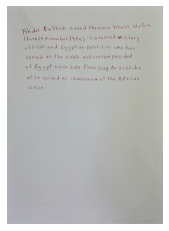

In [53]:
util.show_image(X[0])

In [54]:
#Train the classifier 
X_hinge = []
X_cold = []
X_hog = []




# Calculating features for females' images
for i in range(len(X_train)):
    # extract features
    contours = pre_process(X_train[i])

    hinge_features = features.get_hinge_features(contours)
    X_hinge.append(hinge_features)

    cold_features = features.get_cold_features(contours)
    X_cold.append(cold_features)

    hog_features = features.extract_hog_features(X_train[i])
    X_hog.append(hog_features)


hinge_pca_50, X_hinge_50 = apply_PCA_train(X_hinge, n_components=50)
hinge_pca_60, X_hinge_60 = apply_PCA_train(X_hinge, n_components=60)
cold_pca_180, X_cold_180 = apply_PCA_train(X_cold, n_components=180)
hog_pca_170, X_hog_170 = apply_PCA_train(X_hog, n_components=170)


svm_1 = svm_train(X_hinge_50,y_train)
rft_1 = random_forest_train(X_hinge, y_train)
knn_1 = knn_train(X_hinge_50, y_train)




svm_2 = svm_train( np.hstack((X_hinge_60, X_cold_180, X_hog_170)),y_train)
rft_2 = rft_1
knn_2 = knn_train(X_hinge_60, y_train)





d:\Work\College\Third_Year\NN\Project\Handwriting-Based-Gender-Classification\features.py:96: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)


In [55]:
print(X_hinge)
# print(X_cold)
# print(X_hog)

[array([0.00526329, 0.00604303, 0.01700821, 0.00913765, 0.00928385,
       0.00470284, 0.00190063, 0.00285095, 0.00309462, 0.00190063,
       0.00102342, 0.00891835, 0.02141865, 0.00928385, 0.00943005,
       0.00438607, 0.00243671, 0.00458101, 0.00470284, 0.00116962,
       0.00097468, 0.04198445, 0.01778796, 0.01727625, 0.00984429,
       0.0060674 , 0.00847974, 0.00862594, 0.00211993, 0.00168133,
       0.02987402, 0.01946929, 0.02799776, 0.02446453, 0.0267063 ,
       0.10855528, 0.01313385, 0.00733449, 0.00582373, 0.00662784,
       0.01352372, 0.02344112, 0.03002022, 0.00962499, 0.00382563,
       0.00194937, 0.00302152, 0.01081898, 0.02575599, 0.00872341,
       0.00372816, 0.00219304, 0.0059943 , 0.02751042, 0.00962499,
       0.00338702, 0.00553132, 0.02288067, 0.0164965 , 0.00572626,
       0.03345598, 0.02753478, 0.01776359, 0.03099491, 0.02076074,
       0.0099905 ]), array([0.00977098, 0.01263078, 0.01322657, 0.01148686, 0.01744477,
       0.01916065, 0.00347942, 0.0076499

In [56]:
#Validate


start = timeit.default_timer()

feature_vector = []

# Calculating features for females' images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_50)

y_pred_val = svm_1.predict(feature_vector_pca)

stop = timeit.default_timer()

svm_1_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_val)

print("Accuracy of SVM:", svm_1_accuracy)

print('Time: ', stop - start)

#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for females' images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)


y_pred_val = rft_1.predict(feature_vector)

stop = timeit.default_timer()

rft_1_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_val)

print("Accuracy of random forest:", rft_1_accuracy)    

print('Time: ', stop - start)


#######################################################

start = timeit.default_timer()

feature_vector = []

# Calculating features for females' images
for i in range(len(X_val)):
    # extract features
    contours = pre_process(X_val[i])

    hinge_features = features.get_hinge_features(contours)
    feature_vector.append(hinge_features)

feature_vector_pca = apply_PCA_test(feature_vector, hinge_pca_50)

y_pred_val = knn_1.predict(feature_vector_pca)

stop = timeit.default_timer()


knn_1_accuracy = metrics.accuracy_score(y_true=y_val, y_pred=y_pred_val)

print("Accuracy of knn:", knn_1_accuracy)    

print('Time: ', stop - start)

#######################################################


Accuracy of SVM: 0.6083333333333333
Time:  27.31281540000009
Accuracy of random forest: 0.7
Time:  25.44915680000031
Accuracy of knn: 0.6166666666666667
Time:  25.286105900000166


In [ ]:
#Test (get accuracy and time)

In [ ]:

start = timeit.default_timer()

#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start)